In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import PassiveAggressiveRegressor, SGDRegressor, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from datetime import datetime

In [7]:
spy_lob = pd.read_parquet(r'C:\Users\Эвелина Новикова\SPY_0107.parquet')
qqq_lob = pd.read_parquet(r'C:\Users\Эвелина Новикова\QQQ_0107.parquet')
mrvl_lob = pd.read_parquet(r'C:\Users\Эвелина Новикова\MRVL_0107.parquet')
vxx_lob = pd.read_parquet(r'C:\Users\Эвелина Новикова\VXX_0107.parquet')
vrsk_lob = pd.read_parquet(r'C:\Users\Эвелина Новикова\VRSK_0107.parquet')
anss_lob = pd.read_parquet(r'C:\Users\Эвелина Новикова\ANSS_0107.parquet')
fast_lob = pd.read_parquet(r'C:\Users\Эвелина Новикова\FAST_0107.parquet')

In [137]:
def feature_calc_1(df: pd.DataFrame, lvl_count: int) -> pd.DataFrame:
    mid = (df['bids[0].price'] + df['asks[0].price'])/2
    df['ask_volume'] = sum(df[f"asks[{i}].amount"] for i in range(lvl_count))
    df['bid_volume'] = sum(df[f"bids[{i}].amount"] for i in range(lvl_count))
    imbalance = (df['bid_volume'] - df['ask_volume'])/(df['bid_volume'] + df['ask_volume'] + 1e-8)
    spread = df['bids[0].price'] - df['asks[0].price']
    scaled_mid = (mid - np.min(mid))/(np.max(mid) - np.min(mid) + 1e-8)
    diff_mid = mid.diff().fillna(1e-8)
    df['diff_bids'] = df['bid_volume'].diff().fillna(1e-8)
    df['diff_asks'] = df['ask_volume'].diff().fillna(1e-8)
    diff_ratio = (df['diff_bids'] - df['diff_asks'])/(df['diff_bids'] + df['diff_asks'] + 1e-8)
    df['ask_weighted_price'] = sum(df[f"asks[{i}].price"] * df[f"asks[{i}].amount"] for i in range(lvl_count)) 
    df['bid_weighted_price'] = sum(df[f"bids[{i}].price"] * df[f"bids[{i}].amount"] for i in range(lvl_count))
    vwap = (df['ask_weighted_price'] + df['bid_weighted_price']) / (df['ask_volume'] + df['bid_volume'])
    scaled_vwap = vwap / (mid + 1e-8)
    features = pd.DataFrame({'scaled_mid': scaled_mid[1:], 'imbalance': imbalance[1:], 'spread': spread[1:], 
                             'diff_mid': diff_mid[1:], 'diff_ratio': diff_ratio[1:], 'scaled_vwap': scaled_vwap[1:]})
    return features, mid[:len(mid)-1]

In [183]:
def train_test_split(X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    X_train = X.iloc[:int(len(X)*0.8)]
    y_train = y.iloc[:int(len(X)*0.8)]
    X_test = X.iloc[int(len(X)*0.8):]
    y_test = y.iloc[int(len(X)*0.8):]
    return X_train, y_train, X_test, y_test

In [189]:
X, y = feature_calc_1(spy_lob, 20)

In [191]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

### Ridge

In [205]:
n_alphas_ridge = 100
alphas_ridge = np.logspace(-5, 5, n_alphas_ridge)

coefs_ridge = []   
mape_train_ridge = [] 
mape_test_ridge = [] 

for i, a in enumerate(alphas_ridge):
    if i % 10 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)
    mape_train_ridge.append(mean_absolute_percentage_error(y_train, ridge.predict(X_train)))
    mape_test_ridge.append(mean_absolute_percentage_error(y_test, ridge.predict(X_test)))

Processing 1/100, Alpha = 0.000010
Processing 11/100, Alpha = 0.000102
Processing 21/100, Alpha = 0.001048
Processing 31/100, Alpha = 0.010723
Processing 41/100, Alpha = 0.109750
Processing 51/100, Alpha = 1.123324
Processing 61/100, Alpha = 11.497570
Processing 71/100, Alpha = 117.681195
Processing 81/100, Alpha = 1204.503540
Processing 91/100, Alpha = 12328.467394


In [207]:
finally_alpha_ridge = alphas_ridge[np.argmin(mape_test_ridge)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.0005788280289344116,
 0.01215540489315804)

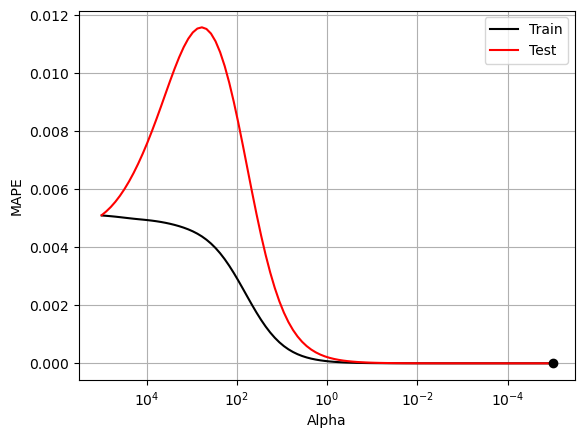

In [209]:
ax = plt.gca()

ax.plot(alphas_ridge, mape_train_ridge, label = 'Train', color = 'black')
ax.plot(alphas_ridge, mape_test_ridge, label = 'Test', color = 'red')

ax.plot(finally_alpha_ridge, mape_test_ridge[np.argmin(mape_test_ridge)], 'o', color = 'black')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAPE")
plt.axis("tight")

In [236]:
ridge = Ridge(alpha = finally_alpha_ridge, max_iter=1000, tol=1e-4, random_state=42)
ridge.fit(X_train, y_train)
y_predict = ridge.predict(X_test)
mean_absolute_percentage_error(y_test, y_predict)

2.1560324886371676e-09

In [220]:
y_predict = ridge.predict(X_test)

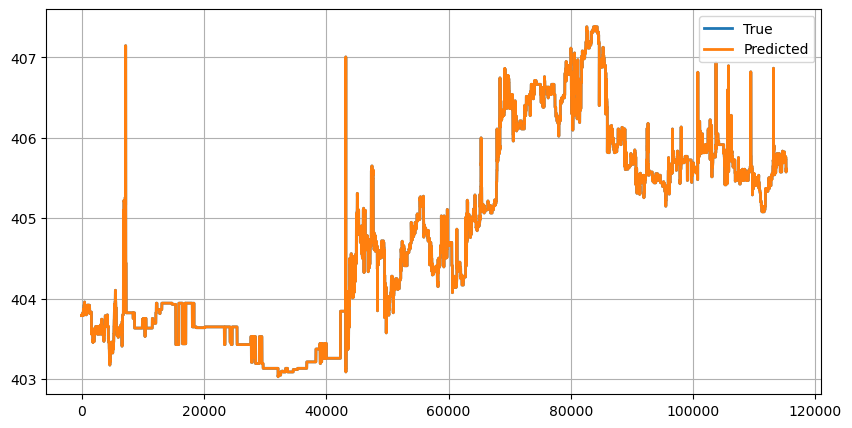

In [234]:
plt.figure(figsize=(10, 5))

plt.plot(y_test.values, label="True", linewidth=2)
plt.plot(y_predict, label="Predicted", linewidth=2)

plt.legend()
plt.grid(True)
plt.show()
